# CVAE + attention practices

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# data_ori = pd.read_csv("C:/Users/andre/Downloads/heart_disease.csv") ## home direc.
data_ori = pd.read_csv('E:/RESEARCH/Datasets/dissertation/heart_disease_sampled.csv') ## heart disease public dataset

In [4]:
# 최소값과 최대값을 확인
min_age = data_ori['age'].min()
max_age = data_ori['age'].max()

# 연령 구간을 10살씩 끊어서 정의
age_bins = list(range(min_age // 10 * 10, max_age + 10, 10))  # 10살 간격으로 구간 정의
age_labels = [f"({i}, {i+10}]" for i in age_bins[:-1]]  # 구간 레이블 생성

# pd.cut()을 사용하여 연령을 구간별로 그룹화
data_ori['age_group'] = pd.cut(data_ori['age'], bins=age_bins, labels=age_labels, right=False)

# age_group을 카테고리형 변수로 변환하고 코드화 (0부터 시작)
data_ori['age_enc'] = pd.Categorical(data_ori['age_group']).codes

In [5]:
data_ori.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,age_enc
0,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0,"(50, 60]",3
1,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0,"(40, 50]",2
2,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
3,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
4,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0,"(40, 50]",2


In [6]:
data_ori = data_ori.drop(['age_group', 'age'], axis=1)

In [7]:
data_ori.columns

Index(['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_enc'],
      dtype='object')

# First trial

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        
        self.fc1 = nn.Linear(input_dim + condition_dim, 128)  # x와 condition 결합 후 크기
        self.fc2 = nn.Linear(128, 128)
        self.fc3_mu = nn.Linear(128, latent_dim)
        self.fc3_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, condition):
        # x와 condition을 결합 (생체신호 + 조건)
        x_condition = torch.cat([x, condition], dim=-1)
        print(f"x_condition shape in Encoder: {x_condition.shape}")  # 차원 출력
        
        h = F.relu(self.fc1(x_condition))
        print(f"h shape after fc1: {h.shape}")
        
        h = F.relu(self.fc2(h))
        print(f"h shape after fc2: {h.shape}")
        
        mu = self.fc3_mu(h)
        logvar = self.fc3_logvar(h)
        
        return mu, logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim):
        super(Decoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(latent_dim + condition_dim, 128)  # z와 condition 결합 후 크기
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
    def forward(self, z, condition):
        # z와 condition을 결합
        z_condition = torch.cat([z, condition], dim=-1)
        print(f"z_condition shape in Decoder: {z_condition.shape}")  # 차원 출력
        
        h = F.relu(self.fc1(z_condition))
        print(f"h shape after fc1: {h.shape}")
        
        h = F.relu(self.fc2(h))
        print(f"h shape after fc2: {h.shape}")
        
        output = self.fc3(h)
        print(f"Output shape: {output.shape}")
        
        return output

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, output_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, condition_dim, latent_dim)
        self.decoder = Decoder(latent_dim, condition_dim, output_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, condition):
        # Encoder에서 mu, logvar 계산
        mu, logvar = self.encoder(x, condition)
        
        # Reparameterization trick
        z = self.reparameterize(mu, logvar)
        print(f"z shape after reparameterization: {z.shape}")
        
        # Decoder에서 output 생성
        reconstructed_x = self.decoder(z, condition)
        return reconstructed_x, mu, logvar

In [ ]:
def loss_function(reconstructed_x, x, mu, logvar):
    # 재구성 손실 (MSE 또는 BCE)
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    
    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # 총 손실
    loss = reconstruction_loss + kl_loss
    return loss

In [ ]:
# 데이터 샘플 예시 (x: 15개의 생체신호, condition: 연령, 성별, 질병)
x = torch.randn(32, 15)  # 배치 크기: 32, 생체신호 15개
condition = torch.randn(32, 3)  # 배치 크기: 32, 연령, 성별, 질병 3개

# 차원 출력
print(f"x shape: {x.shape}")
print(f"condition shape: {condition.shape}")

model = CVAE(input_dim=15, condition_dim=3, latent_dim=10, output_dim=15)
output, mu, logvar = model(x, condition)

In [ ]:
# 랜덤 시드 설정 (재현성을 위해)
np.random.seed(42)
torch.manual_seed(42)

# 예시 데이터 생성
num_samples = 1000  # 샘플 수

# 생체신호 변수 (15개) - 예시로 임의의 값 생성
biometric_signals = np.random.rand(num_samples, 15)

# 연령 변수 (0 ~ 80세, 10단위로 나눈 연령대)
age_groups = np.random.choice([0, 1, 2, 3, 4], num_samples)  # 0: 10대, 1: 20대, 2: 30대, 3: 40대, 4: 50대 이상
ages = age_groups * 10 + np.random.randint(0, 10, num_samples)  # 나이

# 성별 변수 (0: 남성, 1: 여성)
sex = np.random.choice([0, 1], num_samples)

# 질병 변수 (타겟, 예시로 두 가지 질병: 0: 건강, 1: 질병1, 2: 질병2)
disease = np.random.choice([0, 1, 2], num_samples)

# DataFrame으로 변환
data = pd.DataFrame(biometric_signals, columns=[f'biometric_{i+1}' for i in range(15)])
data['age'] = ages
data['sex'] = sex
data['age_group'] = age_groups
data['disease'] = disease
data = data.drop('age', axis=1)


# 예시 데이터 확인
print(data.head())

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MedicalDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.x = torch.tensor(data.iloc[:, :-3].values, dtype=torch.float32)  # 생체신호 변수 (15개)
        self.conditions = torch.tensor(data[['age_group', 'sex', 'disease']].values, dtype=torch.float32)  # 조건 변수 (연령, 성별, 질병)
        self.y = torch.tensor(data['disease'].values, dtype=torch.long)  # 질병 변수 (타겟)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.x[idx], self.conditions[idx], self.y[idx]

# 데이터셋 준비
dataset = MedicalDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# 모델 초기화
input_dim = 15  # 생체신호 변수 개수
condition_dim = 3  # age, sex, disease
latent_dim = 10  # 잠재 공간 차원
output_dim = 15  # 생체신호 출력 차원

model = CVAE(input_dim, condition_dim, latent_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 모델 학습
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, condition, y in dataloader:
        x = x.to(device)
        condition = condition.to(device)

        # 모델 순전파
        reconstructed_x, mu, logvar = model(x, condition)

        # 손실 함수 계산
        loss = loss_function(reconstructed_x, x, mu, logvar)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [ ]:
def sample_virtual_patient_conditions(data, num_samples=num_samples):
    # 원본 데이터에서 조건 분포를 기준으로 샘플링
    conditions = []
    for _ in range(num_samples):
        # 예시: 성별, 연령대, 질병을 샘플링
        gender = np.random.choice(data['sex'].unique())
        age_group = np.random.choice(data['age_group'].unique())
        disease = np.random.choice(data['disease'].unique())
        conditions.append([gender, age_group, disease])
    return torch.tensor(conditions, dtype=torch.float32)

# 가상 환자 조건 샘플링
virtual_conditions = sample_virtual_patient_conditions(data, num_samples=100)
virtual_conditions = virtual_conditions.to(device)

In [ ]:
def generate_synthetic_data(model, conditions):
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        # 가상 조건에 대해 잠재 공간에서 샘플링
        latent_space_sample = torch.randn(conditions.size(0), latent_dim).to(device)  # 잠재 벡터
        synthetic_data = model.decoder(latent_space_sample, conditions)
    return synthetic_data

# synthetic data 생성
synthetic_data = generate_synthetic_data(model, virtual_conditions)
# print(synthetic_data)

In [ ]:
synthetic_data[99]

# Second trial

In [ ]:
data = data_ori.copy()

* 데이터 처리 및 정의

In [ ]:
class BiometricDataset(Dataset):
    def __init__(self, data, scaler=None):
        self.features = data.drop(columns=['age_enc', 'sex', 'target']).values  # 15개 생체신호 변수
        self.age = data['age_enc'].values
        self.gender = data['sex'].values
        self.disease = data['target'].values
        

        # 스케일링
        if scaler is None:
            self.scaler = StandardScaler().fit(self.features)
        else:
            self.scaler = scaler
        self.features = self.scaler.transform(self.features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.features[idx], dtype=torch.float32),
            'age_enc': torch.tensor(self.age[idx], dtype=torch.float32),
            'sex': torch.tensor(self.gender[idx], dtype=torch.float32),
            'target': torch.tensor(self.disease[idx], dtype=torch.float32)
        }

* CVAE 모델 정의

In [ ]:
import torch
import torch.nn as nn

class CVAEWithAttention(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAEWithAttention, self).__init__()
        
        # 인코더: input_dim + condition_dim 크기 조정
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),  # 크기 조정
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        # 디코더: latent_dim + condition_dim 크기 조정
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU()
        )
        
        # Attention 블록: self_attention과 cross_attention
        self.self_attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)
        self.cross_attention = nn.MultiheadAttention(embed_dim=256, num_heads=4)
        
        # 최종 출력 크기
        self.decoder_out = nn.Linear(256, input_dim)
    
    def encode(self, x, condition):
        # 인코더에서 x와 condition을 결합
        h = self.encoder(torch.cat([x, condition], dim=1))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, condition):
        # 디코더에서 z와 condition을 결합
        h = self.decoder_fc(torch.cat([z, condition], dim=1))
        
        # Self-attention 적용
        h = h.unsqueeze(0)  # (1, batch_size, feature_size)
        attn_output, _ = self.self_attention(h, h, h)
        
        # Cross-attention 적용
        condition_vector = condition.unsqueeze(0).expand_as(attn_output)  # (1, batch_size, feature_size)
        attn_output, _ = self.cross_attention(attn_output, condition_vector, condition_vector)
        
        h = attn_output.squeeze(0)  # (batch_size, feature_size)
        return self.decoder_out(h)
    
    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, condition)
        return recon_x, mu, logvar

* 손실함수 정의

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

* 모델 학습 코드

In [ ]:
def train_model(model, dataloader, num_epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            features = batch['features']
            age = batch['age_enc'].unsqueeze(1)
            gender = batch['sex'].unsqueeze(1)
            disease = batch['target'].unsqueeze(1)
            
            # condition 생성
            condition = torch.cat([age, gender, disease], dim=1)
            
            optimizer.zero_grad()
            recon_features, mu, logvar = model(features, condition)
            loss = loss_function(recon_features, features, mu, logvar)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

* Synthetic data 생성

In [ ]:
def generate_synthetic_data(model, condition_list, num_samples=100):
    model.eval()
    synthetic_data = []
    with torch.no_grad():
        for condition in condition_list:
            condition_tensor = torch.tensor(condition, dtype=torch.float32).unsqueeze(0)
            z = torch.randn(num_samples, model.latent_dim)
            samples = model.decode(z, condition_tensor.repeat(num_samples, 1))
            synthetic_data.append(samples.numpy())
    return np.vstack(synthetic_data)

* 전체 코드 실행 예시

In [ ]:
# 데이터 로드 및 전처리
scaler = StandardScaler()
scaler.fit(data.drop(columns=['age_enc', 'sex', 'target']).values)  # 생체신호 변수만 사용하여 fit

# PyTorch Dataset 생성
dataset = BiometricDataset(data, scaler=scaler)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# 모델 초기화 및 학습
input_dim = 11  # 생체신호 변수 개수
condition_dim = 3  # 연령, 성별, 질병 변수 개수
latent_dim = 10  # latent space 차원
model = CVAEWithAttention(input_dim, condition_dim, latent_dim)
train_model(model, dataloader)

In [ ]:
# synthetic data 생성
# 가정: 가상 환자 조건 샘플링 (예: [(50, 1, 2), (40, 0, 1)] 등) -> 연령, 성별, 질병 정보
condition_list = [(50, 1, 2), (40, 0, 1)]
synthetic_data = generate_synthetic_data(model, condition_list)
print("Synthetic Data 생성 완료")

# Third trial

In [237]:
data_try = data_ori.copy()

In [238]:
data_try.columns

Index(['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_enc'],
      dtype='object')

In [239]:
data_try.target.value_counts()

target
1    526
0    260
Name: count, dtype: int64

In [22]:
# 2. 연령, 성별, 질병 변수를 condition으로 사용하기 위해 분리
x_data = data_try.drop(['sex', 'age_enc', 'target'], axis=1)
conditions = data_try[['age_enc', 'sex', 'target']]  # 연령, 성별, 질병 변수

# 3. 스케일링
scaler = StandardScaler()
x_data_scaled = scaler.fit_transform(x_data)

# 4. PyTorch Dataset 생성
class MedicalDataset(Dataset):
    def __init__(self, x_data, conditions):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.conditions = torch.tensor(conditions.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.conditions[idx]

dataset = MedicalDataset(x_data_scaled, conditions)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CVAE 모델 정의
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim):
        super(CVAE, self).__init__()
        
        # 인코더
        self.latent_dim = latent_dim  # latent_dim 속성 추가
        self.encoder_fc1 = nn.Linear(input_dim + cond_dim, 128)
        self.encoder_fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        # 디코더
        self.decoder_fc1 = nn.Linear(latent_dim + cond_dim, 64)
        self.decoder_fc2 = nn.Linear(64, 128)
        
        # Attention Blocks
        self.self_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        
        # Reconstructing layer
        self.decoder_fc3 = nn.Linear(128, input_dim)
        
    def encode(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        x = F.relu(self.decoder_fc1(x))
        x = F.relu(self.decoder_fc2(x))
        
        # Self-Attention: 생체신호-연령, 생체신호-성별 특징 반영
        x = x.unsqueeze(0)  # (1, batch, feature) 형식으로 변환
        x, _ = self.self_attention(x, x, x)
        
        # Cross-Attention: 연령, 성별이 생체신호에 주는 영향 반영
        x, _ = self.cross_attention(x, x, x)
        
        x = x.squeeze(0)
        x = self.decoder_fc3(x)
        return x

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, cond)
        return recon_x, mu, logvar

In [24]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

model = CVAE(input_dim=11, cond_dim=3, latent_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, cond_batch in dataloader:
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x_batch, cond_batch)
        loss = loss_function(recon_x, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}")

Epoch 1, Loss: 11.023799148831355
Epoch 2, Loss: 10.529149994595361
Epoch 3, Loss: 10.064863559247277
Epoch 4, Loss: 9.753921567028716
Epoch 5, Loss: 9.709560151621888
Epoch 6, Loss: 9.612575754257863
Epoch 7, Loss: 9.626881800838403
Epoch 8, Loss: 9.487061672841623
Epoch 9, Loss: 9.415604084199318
Epoch 10, Loss: 9.381310149913526
Epoch 11, Loss: 9.327868900832936
Epoch 12, Loss: 9.335747211640724
Epoch 13, Loss: 9.339203793280603
Epoch 14, Loss: 9.121593329742664
Epoch 15, Loss: 9.125183454906667
Epoch 16, Loss: 9.088118186737137
Epoch 17, Loss: 8.978340420710829
Epoch 18, Loss: 8.952489702452837
Epoch 19, Loss: 8.881169947655753
Epoch 20, Loss: 8.893800536488152
Epoch 21, Loss: 8.82877658523676
Epoch 22, Loss: 8.830778068561894
Epoch 23, Loss: 8.798233362251262
Epoch 24, Loss: 8.73868811221523
Epoch 25, Loss: 8.660898087285554
Epoch 26, Loss: 8.704927672563315
Epoch 27, Loss: 8.690282263525267
Epoch 28, Loss: 8.61813292369891
Epoch 29, Loss: 8.630260962566346
Epoch 30, Loss: 8.56510

In [25]:
# 조건에 따른 synthetic data 생성 함수
def generate_synthetic_data(model, sample_conditions_list):
    synthetic_samples = []

    for condition in sample_conditions_list:
        age, gender, disease = condition

        # 조건 텐서로 변환
        condition_tensor = torch.tensor([age, gender, disease], dtype=torch.float32).unsqueeze(0)

        # 잠재 공간에서 샘플링하여 synthetic data 생성
        with torch.no_grad():
            z = torch.randn(1, model.latent_dim)  # 모델의 latent_dim 크기에 맞게 샘플링
            synthetic_sample = model.decode(z, condition_tensor)  # 조건을 적용하여 디코더로 생성
            synthetic_samples.append(synthetic_sample.squeeze(0).numpy())  # numpy 배열로 변환

    synthetic_data = np.array(synthetic_samples)
    return synthetic_data

In [346]:
def sample_conditions(data, n):
    # 조건 변수 선택
    condition_data = data[['age_enc', 'sex', 'target']]
    
    # 목표 비율 계산 (target, sex, age_enc 각 클래스가 동일하게 분포된다고 가정)
    total_count = len(condition_data) + n
    unique_targets = condition_data['target'].unique()
    unique_sexes = condition_data['sex'].unique()
    unique_ages = condition_data['age_enc'].unique()
    
    target_goal_count = total_count / len(unique_targets)
    sex_goal_count = total_count / (len(unique_targets) * len(unique_sexes))
    age_goal_count = total_count / (len(unique_targets) * len(unique_sexes) * len(unique_ages))
    
    # 최종 샘플링 조건 리스트
    sampled_conditions = []
    
    for target in unique_targets:
        # target별로 필요한 샘플 수 계산
        current_target_count = condition_data[condition_data['target'] == target].shape[0]
        target_sample_count = max(0, int(target_goal_count - current_target_count))
        
        if target_sample_count > 0:
            for sex in unique_sexes:
                # sex별로 필요한 샘플 수 계산
                target_sex_data = condition_data[(condition_data['target'] == target) & (condition_data['sex'] == sex)]
                current_sex_count = target_sex_data.shape[0]
                sex_sample_count = max(0, int(sex_goal_count - current_sex_count))
                
                if sex_sample_count > 0:
                    for age in unique_ages:
                        # age_enc별로 필요한 샘플 수 계산
                        current_age_count = target_sex_data[target_sex_data['age_enc'] == age].shape[0]
                        age_sample_count = max(0, int(age_goal_count - current_age_count))
                        
                        # 필요한 샘플 수만큼 조건 추가
                        sampled_conditions.extend([[age, sex, target]] * age_sample_count)
                        
    # 최종 샘플링 조건 리스트 반환
    return sampled_conditions[:n]  # 요청된 n개만 반환


# 함수 실행 예시
sampled_conditions_list = sample_conditions(data_try, 260)
# print(sampled_conditions_list)

In [347]:
# 샘플링된 조건에 따른 synthetic data 생성
synthetic_data = generate_synthetic_data(model, sampled_conditions_list)
synthetic_data = scaler.inverse_transform(synthetic_data)  # 스케일링 역변환
# print("Synthetic Data Generated:\n", synthetic_data)

In [348]:
synthetic_data.shape

(260, 11)

In [349]:
data_try.columns

Index(['age_enc', 'sex', 'target', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [350]:
# 예시용 변수 이름 목록 (생체신호 변수 이름 11개)
signal_columns = ['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang','oldpeak', 'slope', 'ca', 'thal']

def create_synthetic_dataframe(synthetic_data, sample_conditions_list):
    # 1. synthetic_data를 DataFrame으로 변환
    synthetic_df = pd.DataFrame(synthetic_data, columns=signal_columns)
    
    # 2. sample_conditions_list를 DataFrame으로 변환
    conditions_df = pd.DataFrame(sample_conditions_list, columns=['age_enc', 'sex', 'target'])
    
    # 3. synthetic_df와 conditions_df를 열 방향으로 결합
    combined_df = pd.concat([conditions_df, synthetic_df], axis=1)
    
    return combined_df

In [351]:
synthetic_df = create_synthetic_dataframe(synthetic_data, sampled_conditions_list)

print("Final Synthetic DataFrame Shape:", synthetic_df.shape)
print("Synthetic DataFrame:\n", synthetic_df)

Final Synthetic DataFrame Shape: (260, 14)
Synthetic DataFrame:
      age_enc  sex  target        cp    trestbps        chol       fbs  \
0          2    1       0  0.745298  115.875313  215.286880 -0.011856   
1          2    1       0  0.937059  130.197876  259.437744 -0.037308   
2          2    1       0  0.815450  130.289551  231.322128 -0.028973   
3          2    1       0  0.263390  123.105484  249.743134  0.385161   
4          1    1       0  0.347753  120.127998  224.843948 -0.019644   
..       ...  ...     ...       ...         ...         ...       ...   
255        5    0       0 -0.467913  146.262314  273.678772 -0.058663   
256        5    0       0  0.514561  130.019974  219.892151 -0.053984   
257        5    0       0  1.165741  153.643204  309.787872  0.112906   
258        5    0       0  0.972478  135.467651  217.171631  0.053369   
259        5    0       0 -0.106641  162.670761  276.136383 -0.109894   

      restecg     thalach     exang   oldpeak     slope   

In [352]:
synthetic_df.target.value_counts()

target
0    260
Name: count, dtype: int64

In [353]:
data_try.columns

Index(['age_enc', 'sex', 'target', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [354]:
synthetic_df.columns

Index(['age_enc', 'sex', 'target', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [355]:
# 예시: synthetic_df와 data의 컬럼 순서를 맞추기
data_try = data_try[synthetic_df.columns]

In [356]:
data_try.columns

Index(['age_enc', 'sex', 'target', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [357]:
# synthetic_df와 data를 결합
combined_df = pd.concat([data_try, synthetic_df], ignore_index=True)

# 결과 확인
print("Combined DataFrame shape:", combined_df.shape)
print("Combined DataFrame:\n", combined_df.head())
print("------------------------------------------")
print("Combined DataFrame:\n", combined_df.tail())

Combined DataFrame shape: (1046, 14)
Combined DataFrame:
    age_enc  sex  target   cp  trestbps   chol  fbs  restecg  thalach  exang  \
0        3    1       0  0.0     120.0  188.0  0.0      1.0    113.0    0.0   
1        2    0       0  0.0     132.0  341.0  1.0      0.0    136.0    1.0   
2        4    0       0  2.0     130.0  263.0  0.0      1.0     97.0    0.0   
3        4    0       0  2.0     130.0  263.0  0.0      1.0     97.0    0.0   
4        2    1       0  2.0     108.0  243.0  0.0      1.0    152.0    0.0   

   oldpeak  slope   ca  thal  
0      1.4    1.0  1.0   3.0  
1      3.0    1.0  0.0   3.0  
2      1.2    1.0  1.0   3.0  
3      1.2    1.0  1.0   3.0  
4      0.0    2.0  0.0   2.0  
------------------------------------------
Combined DataFrame:
       age_enc  sex  target        cp    trestbps        chol       fbs  \
1041        5    0       0 -0.467913  146.262314  273.678772 -0.058663   
1042        5    0       0  0.514561  130.019974  219.892151 -0.05398

In [358]:
combined_df.target.value_counts()

target
1    526
0    520
Name: count, dtype: int64

In [359]:
data_try.target.value_counts()

target
1    526
0    260
Name: count, dtype: int64

In [360]:
data_vis = combined_df.copy()

<Figure size 1000x700 with 0 Axes>

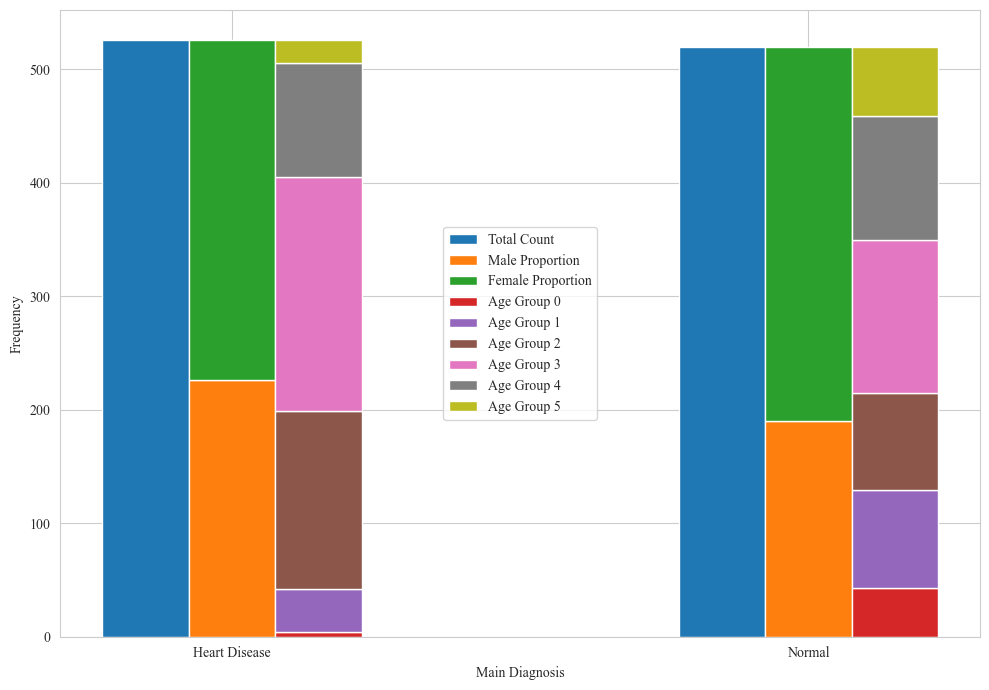

In [361]:
# main_dx별 개수 계산
main_dx_counts = data_vis['target'].value_counts()

# main_dx별 성별 비율 계산 (성별이 'M'과 'F'로 나누어짐)
gender_counts = data_vis.groupby(['target', 'sex']).size().unstack(fill_value=0)
gender_ratio = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# main_dx별 연령대 비율 계산 (연령대별 비율 계산)
age_counts = data_vis.groupby(['target', 'age_enc']).size().unstack(fill_value=0)
age_ratio = age_counts.div(age_counts.sum(axis=1), axis=0)

# 그래프 크기 설정
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# x 위치 설정 (막대의 중심이 각 main_dx에 맞도록)
x = range(len(main_dx_counts))

# main_dx의 개수에 대한 막대 그리기
bar_width = 0.15
plt.bar(x, main_dx_counts.values, width=bar_width, label='Total Count', align='center')

# 성별 비율에 대한 막대 그리기 (남성 비율, 여성 비율)
male_height = gender_ratio.loc[main_dx_counts.index, 0] * main_dx_counts.values
female_height = gender_ratio.loc[main_dx_counts.index, 1] * main_dx_counts.values
plt.bar([i + bar_width for i in x], male_height, width=bar_width, label='Male Proportion', align='center')
plt.bar([i + bar_width for i in x], female_height, bottom=male_height, width=bar_width, label='Female Proportion', align='center')

# 연령대 비율에 대한 막대 그리기 (각 연령대에 대해 표시)
age_bar_width = 0.15  # 연령대 막대 너비 설정
bottoms = 0

# 연령대별 막대 그리기
for i, age_group in enumerate(age_ratio.columns):
    age_height = age_ratio.loc[main_dx_counts.index, age_group] * main_dx_counts.values
    plt.bar([i + bar_width*2 for i in x], age_height, width=age_bar_width, label=f'Age Group {age_group}', align='center', bottom=bottoms)
    # 누적된 bottom 값 업데이트
    bottoms += age_height

# x축, y축, 레이블 설정
plt.xlabel('Main Diagnosis')
plt.ylabel('Frequency')

# x축의 main_dx 이름을 세 개의 막대 중앙에 맞추기
plt.xticks([i + bar_width for i in x], main_dx_counts.index, rotation=0)
ax.set_xticklabels(['Heart Disease', 'Normal'])

# Legend 이름 변경
plt.legend(loc='center')

# 그래프 표시
plt.tight_layout()
plt.show()

# Fourth Trial

In [362]:
data_fourth = data_ori.copy()

In [365]:
# 1.1 Scaler로 연속형 데이터 정규화
scaler = StandardScaler()
continuous_features =['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang','oldpeak', 'slope', 'ca', 'thal']
data_fourth[continuous_features] = scaler.fit_transform(data_fourth[continuous_features])

In [366]:
data_fourth.columns

Index(['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_enc'],
      dtype='object')

In [367]:
# 1.2 PyTorch Dataset 정의
class MedicalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = dataframe[continuous_features].values.astype(np.float32)
        self.conditions = dataframe[['age_enc', 'sex', 'target']].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.conditions[idx])

# Dataset 및 DataLoader 생성
dataset = MedicalDataset(data_fourth)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [370]:
# Multi-Head Self-Attention Block
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embed size must be divisible by heads"

        self.values = nn.Linear(self.head_dim, embed_size, bias=False)
        self.keys = nn.Linear(self.head_dim, embed_size, bias=False)
        self.queries = nn.Linear(self.head_dim, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        N, seq_length, embed_size = x.shape
        values = self.values(x)
        keys = self.keys(x)
        queries = self.queries(x)

        # Attention score 계산
        energy = torch.einsum("nqk,nvk->nqv", [queries, keys])  # (N, seq_length, seq_length)
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=2)

        out = torch.einsum("nqv,nvk->nqk", [attention, values])
        out = self.fc_out(out)
        return out


# Cross-Attention Block
class CrossAttention(nn.Module):
    def __init__(self, embed_size):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, x, context):
        queries = self.query(x)
        keys = self.key(context)
        values = self.value(context)

        # Attention score 계산
        energy = torch.einsum("nqk,nvk->nqv", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=2)

        out = torch.einsum("nqv,nvk->nqk", [attention, values])
        return out


# CVAE 모델 정의
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        self.self_attention = MultiHeadSelfAttention(embed_size=128, heads=4)
        self.cross_attention = CrossAttention(embed_size=128)
        self.final_layer = nn.Linear(128, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, conditions):
        # 인코더
        encoder_input = torch.cat([x, conditions], dim=1)
        encoded = self.encoder(encoder_input)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        # 디코더
        decoder_input = torch.cat([z, conditions], dim=1)
        decoded = self.decoder(decoder_input)

        # Attention 적용
        decoded = self.self_attention(decoded.unsqueeze(1)).squeeze(1)
        decoded = self.cross_attention(decoded.unsqueeze(1), conditions.unsqueeze(1)).squeeze(1)

        # 최종 출력
        reconstructed = self.final_layer(decoded)
        return reconstructed, mu, logvar

In [371]:
from torch.optim import Adam

# 모델 및 손실 함수 정의
model = CVAE(input_dim=11, condition_dim=3, latent_dim=10)
optimizer = Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# 학습 루프
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_features, batch_conditions in dataloader:
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(batch_features, batch_conditions)
        loss = loss_function(reconstructed, batch_features, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 32x128)